In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

In [194]:
df_normal_quality

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,3SsnPorch,ScreenPorch,PoolYN,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms
0,909176150,856,126000,30,RL,62.472926,7890,Pave,0.0,1,...,0,166,no,0.0,NO,3,2010,WD,Normal,2.0
1,905476230,1049,139500,120,RL,42.000000,4235,Pave,0.0,1,...,0,0,no,0.0,NO,2,2009,WD,Normal,3.0
2,911128020,1001,124900,30,C (all),60.000000,6060,Pave,0.0,1,...,86,0,no,0.0,NO,11,2007,WD,Normal,1.0
3,535377150,1039,114000,70,RL,80.000000,8146,Pave,0.0,1,...,0,111,no,0.0,NO,5,2009,WD,Normal,1.0
4,534177230,1665,227000,60,RL,70.000000,8400,Pave,0.0,1,...,0,0,no,0.0,NO,11,2009,WD,Normal,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,903205040,952,121000,30,RL,70.105866,8854,Pave,0.0,1,...,0,40,no,0.0,NO,5,2009,WD,Normal,1.0
2329,905402060,1733,139600,20,RL,108.318076,13680,Pave,0.0,2,...,0,0,no,0.0,NO,6,2009,WD,Normal,2.0
2330,909275030,2002,145000,90,RH,82.000000,6270,Pave,0.0,1,...,0,0,no,0.0,NO,8,2007,WD,Normal,2.0
2331,907192040,1842,217500,60,RL,69.884162,8826,Pave,0.0,1,...,0,0,no,0.0,NO,7,2007,WD,Normal,3.5


# Lasso

In [235]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030615490713200075),
                                                                func =np.log, inverse_func=np.exp))])

scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

print('score', scores.mean())
print('standard deviation', scores.std())

lasso_pipe.fit(X,y)

predictions = lasso_pipe.predict(X)
print('predicted prices', predictions)
mae = mean_absolute_error(y, predictions)
print('Mean Absolute Error:', mae)
mpv = predictions.mean()
print ('Mean Predicted Home Value', mpv)
mhv = y.mean()
print ('Mean  Home Value', mhv)


score 0.9508125912427354
standard deviation 0.004995823435935556
predicted prices [125415.72820466 130117.32966261 115865.46638959 ... 153059.8841348
 224552.16436075 223787.78834833]
Mean Absolute Error: 10279.979072500728
Mean Predicted Home Value 172915.18461252082
Mean  Home Value 173427.01285897984


In [323]:
lasso_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
lasso_regressor = lasso_pipe.named_steps['Regressor'].regressor_
coefficients = lasso_regressor.coef_

# Get the feature names after preprocessing
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

feature_importance.tail(20)

,Feature,Importance
89,one-hot-encoder__Neighborhood_OldTown,-0.004034
145,one-hot-encoder__Exterior1st_HdBoard,-0.004873
120,one-hot-encoder__HouseStyle_1Story,-0.004916
172,one-hot-encoder__Foundation_BrkTil,-0.005742
98,one-hot-encoder__Condition1_Feedr,-0.006147
2,robust_scaler__LotFrontage,-0.006841
162,one-hot-encoder__Exterior2nd_Plywood,-0.007808
123,one-hot-encoder__HouseStyle_2Story,-0.010339
153,one-hot-encoder__Exterior2nd_AsbShng,-0.012563
92,one-hot-encoder__Neighborhood_SawyerW,-0.014731


In [243]:
predictions[1]

130117.32966261066

In [245]:
mae = mean_absolute_error(y, price_preds)
print('Mean Absolute Error:', mae)
mpv = price_preds.mean()
print ('Mean Predicted Home Value', mpv)
mhv = y.mean()
print ('Mean  Home Value', mhv)

Mean Absolute Error: 10722.339692291198
Mean Predicted Home Value 172876.79145402642
Mean  Home Value 173427.01285897984


In [244]:
price_preds = cross_val_predict(lasso_pipe, X, y, cv= kf)
price_preds[1]

131358.69753877266

In [236]:
ridge_pipe

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bsmt...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Regressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=22.384020959927625)))])

In [198]:
lasso_pipe

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bsmt...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Regressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Lasso(alpha=0.00030615490713200075)))])

In [216]:
lasso_pipe.fit(X_train, y_train)
print('train', lasso_pipe.score(X_train,y_train))
print('test', lasso_pipe.score(X_test,y_test))

train 0.9580338861454313
test 0.9412537707468278


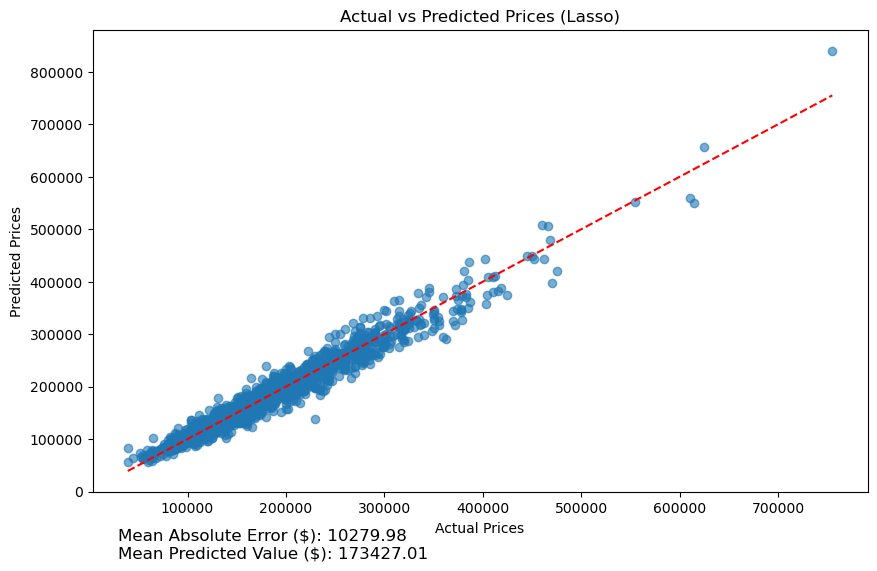

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Lasso)')
plt.figtext(0.15, 0.03, f'Mean Absolute Error ($): {mae:.2f}', ha='left', fontsize=12)
plt.figtext(0.15, 0.00, f'Mean Predicted Value ($): {mhv:.2f}', ha='left', fontsize=12)
plt.show()

In [139]:
predictions.mean()

172915.18461252082

In [140]:
np.exp(shap_values.base_values)

array([158265.06181799, 158265.06181799, 158265.06181799, ...,
       158265.06181799, 158265.06181799, 158265.06181799])

In [287]:
# Create a SHAP explainer for the Lasso model
explainer = shap.Explainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values = explainer(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names)

# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df[prefix] = shap_values_df[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
bv = shap_values.base_values[0]
dollar_shap_values = np.exp(bv + shap_values_df) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

# Create a shap.Explanation with scaled shap values and correct feature names 
exp = shap.Explanation(dollar_shap_values.values, 
                       np.exp(shap_values.base_values),
                       X_new_order)

In [311]:
explainer = shap.Explainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values = explainer(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names)

bv = shap_values.base_values[0]
dollar_shap_values = np.exp(bv + shap_values_df) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_all = shap.Explanation(dollar_shap_values.values, 
                       np.exp(shap_values.base_values),
                       test)

In [307]:
lasso_pipe.named_steps['Preprocess'].transform(X)

array([[-0.91734198, -0.4       , -0.33139011, ...,  0.        ,
         1.        ,  1.        ],
       [-0.60453809,  1.4       , -1.23273964, ...,  0.        ,
         1.        ,  1.        ],
       [-0.68233387, -0.4       , -0.44026416, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.94003241,  0.8       ,  0.52831699, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.68071313,  0.2       , -0.00509992, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.79254457,  0.2       ,  0.44026416, ...,  0.        ,
         1.        ,  1.        ]])

In [310]:
test = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
test.columns = dollar_shap_values.columns
test

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_Normal
0,-0.917342,-0.4,-0.331390,-0.355114,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,-0.604538,1.4,-1.232740,-1.273687,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.682334,-0.4,-0.440264,-0.815029,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.620746,0.4,0.440264,-0.290777,0.0,0.0,0.0,0.0,0.0,-0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.393841,0.2,0.000000,-0.226941,0.0,0.0,0.0,0.0,0.0,1.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.761750,-0.4,0.004661,-0.112842,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2329,0.504052,-0.6,1.687008,1.100025,0.0,1.0,0.0,0.0,0.0,-1.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2330,0.940032,0.8,0.528317,-0.762252,0.0,0.0,-2.0,0.0,0.0,-0.458333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2331,0.680713,0.2,-0.005100,-0.119879,0.0,0.0,0.0,0.0,0.0,0.541667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


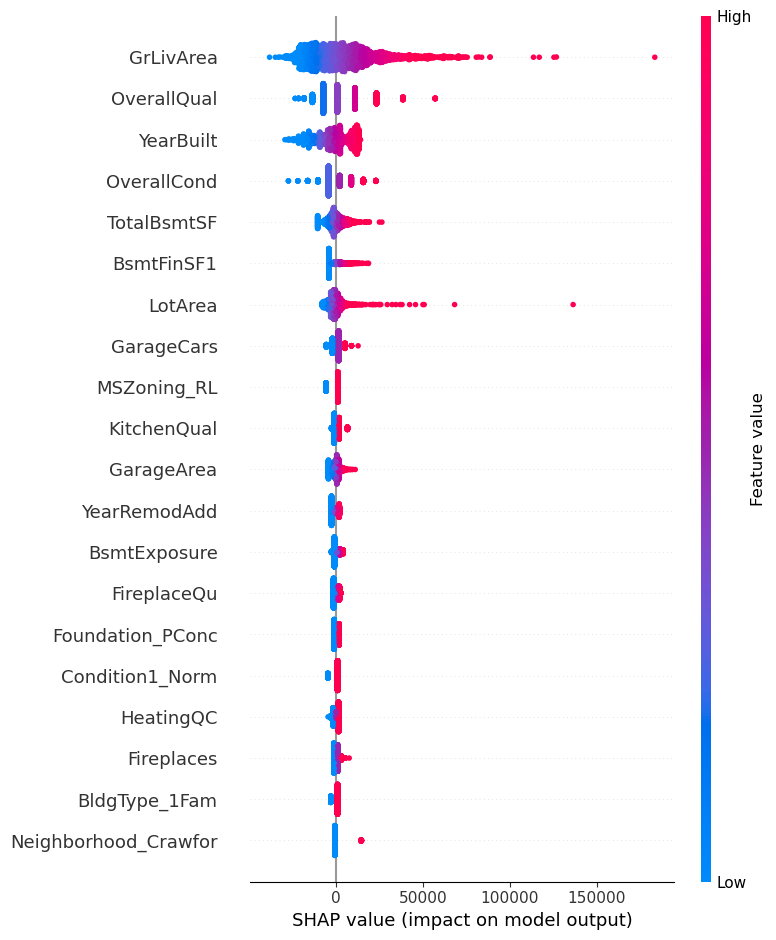

In [312]:
shap.summary_plot(exp_all)

In [344]:
print('mean',X.loc[X.Neighborhood == 'Crawfor'].YearBuilt.mean())
print('median',X.loc[X.Neighborhood == 'Crawfor'].YearBuilt.median())

mean 1942.0533333333333
median 1935.0


In [345]:
print('mean',X.loc[X.Neighborhood == 'CollgCr'].YearBuilt.mean())
print('median',X.loc[X.Neighborhood == 'CollgCr'].YearBuilt.median())

mean 1996.9601769911505
median 2001.0


In [342]:
X.loc[X.Neighborhood == 'CollgCr'].YearBuilt.mean()

1996.9601769911505

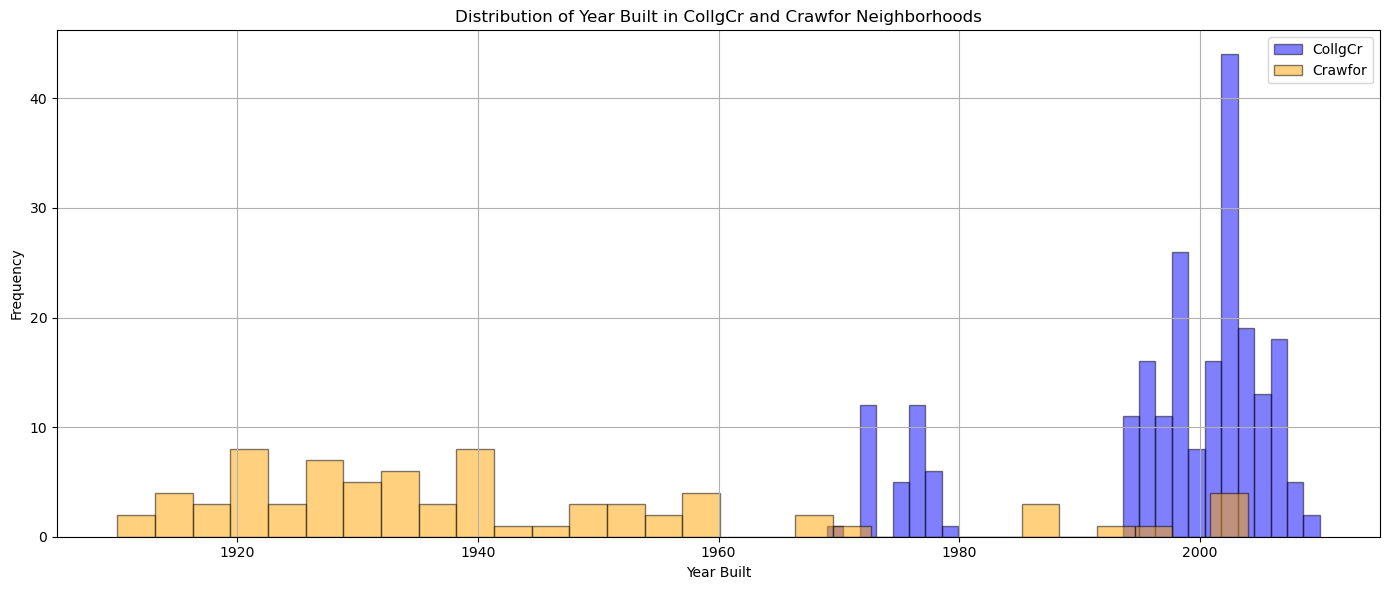

In [353]:
plt.figure(figsize=(14, 6))

# Plot the histogram for 'CollgCr'
plt.hist(collgcr_data['YearBuilt'], bins=30, alpha=0.5, label='CollgCr', edgecolor='black', color='blue')

# Plot the histogram for 'Crawfor'
plt.hist(crawfor_data['YearBuilt'], bins=30, alpha=0.5, label='Crawfor', edgecolor='black', color='orange')

# Add titles and labels
plt.title('Distribution of Year Built in CollgCr and Crawfor Neighborhoods')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

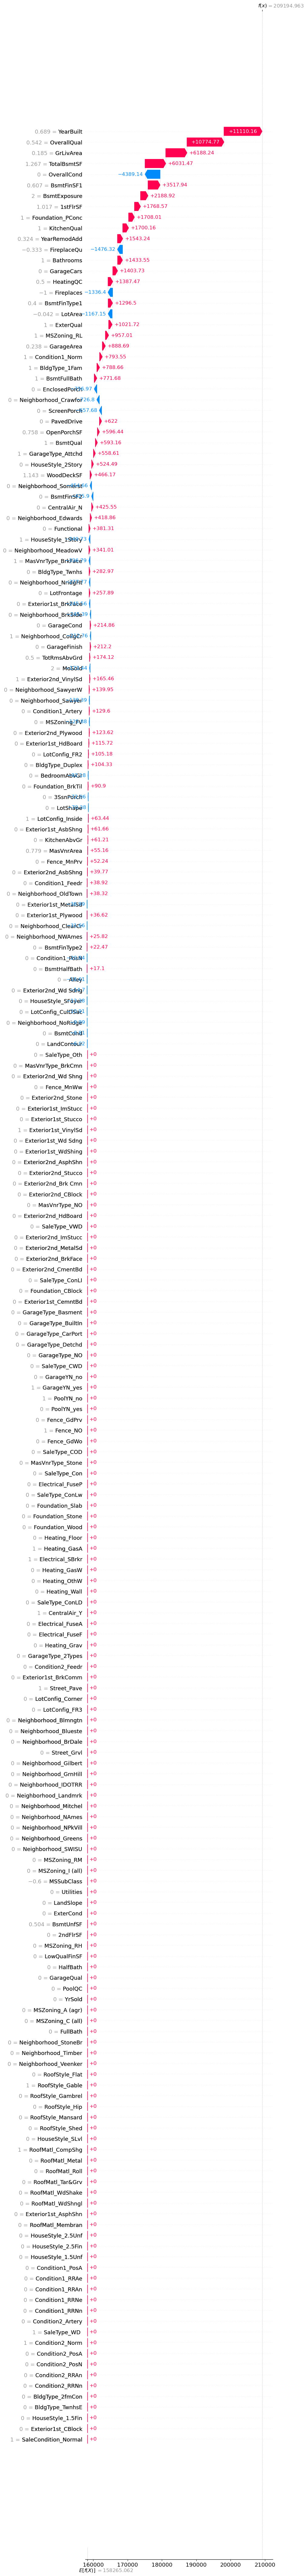

In [336]:
shap.waterfall_plot(exp_all[13], max_display= 250)

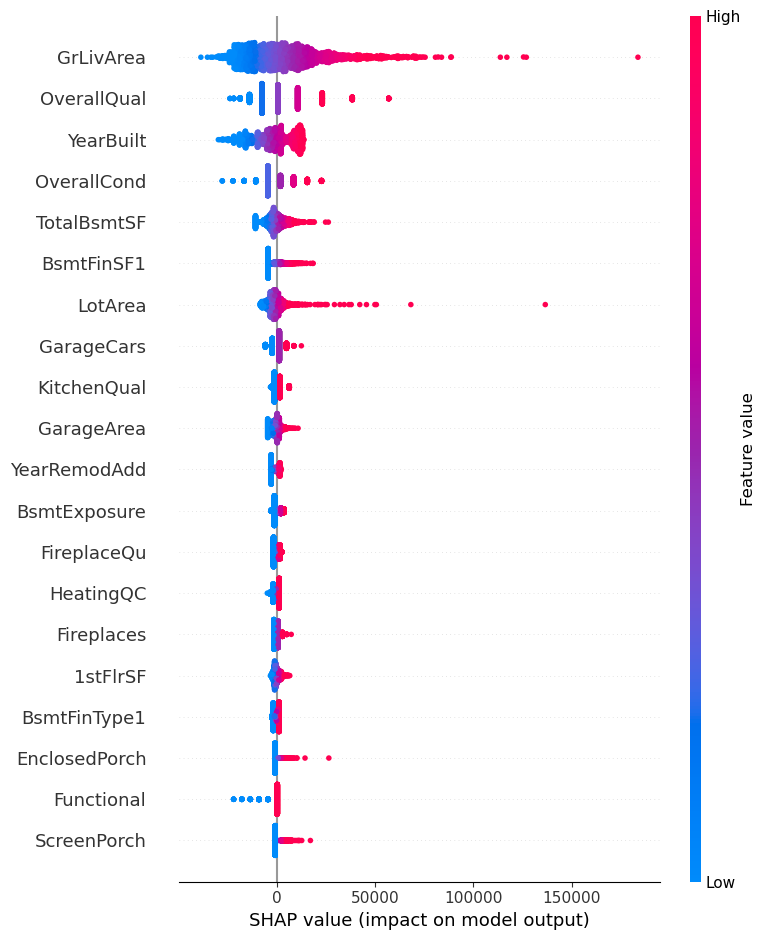

In [300]:
shap.summary_plot(exp)

Actual 214000
Prediction 216726.24140661236
Difference in SHAP and Prediction =  -11407.654769888904


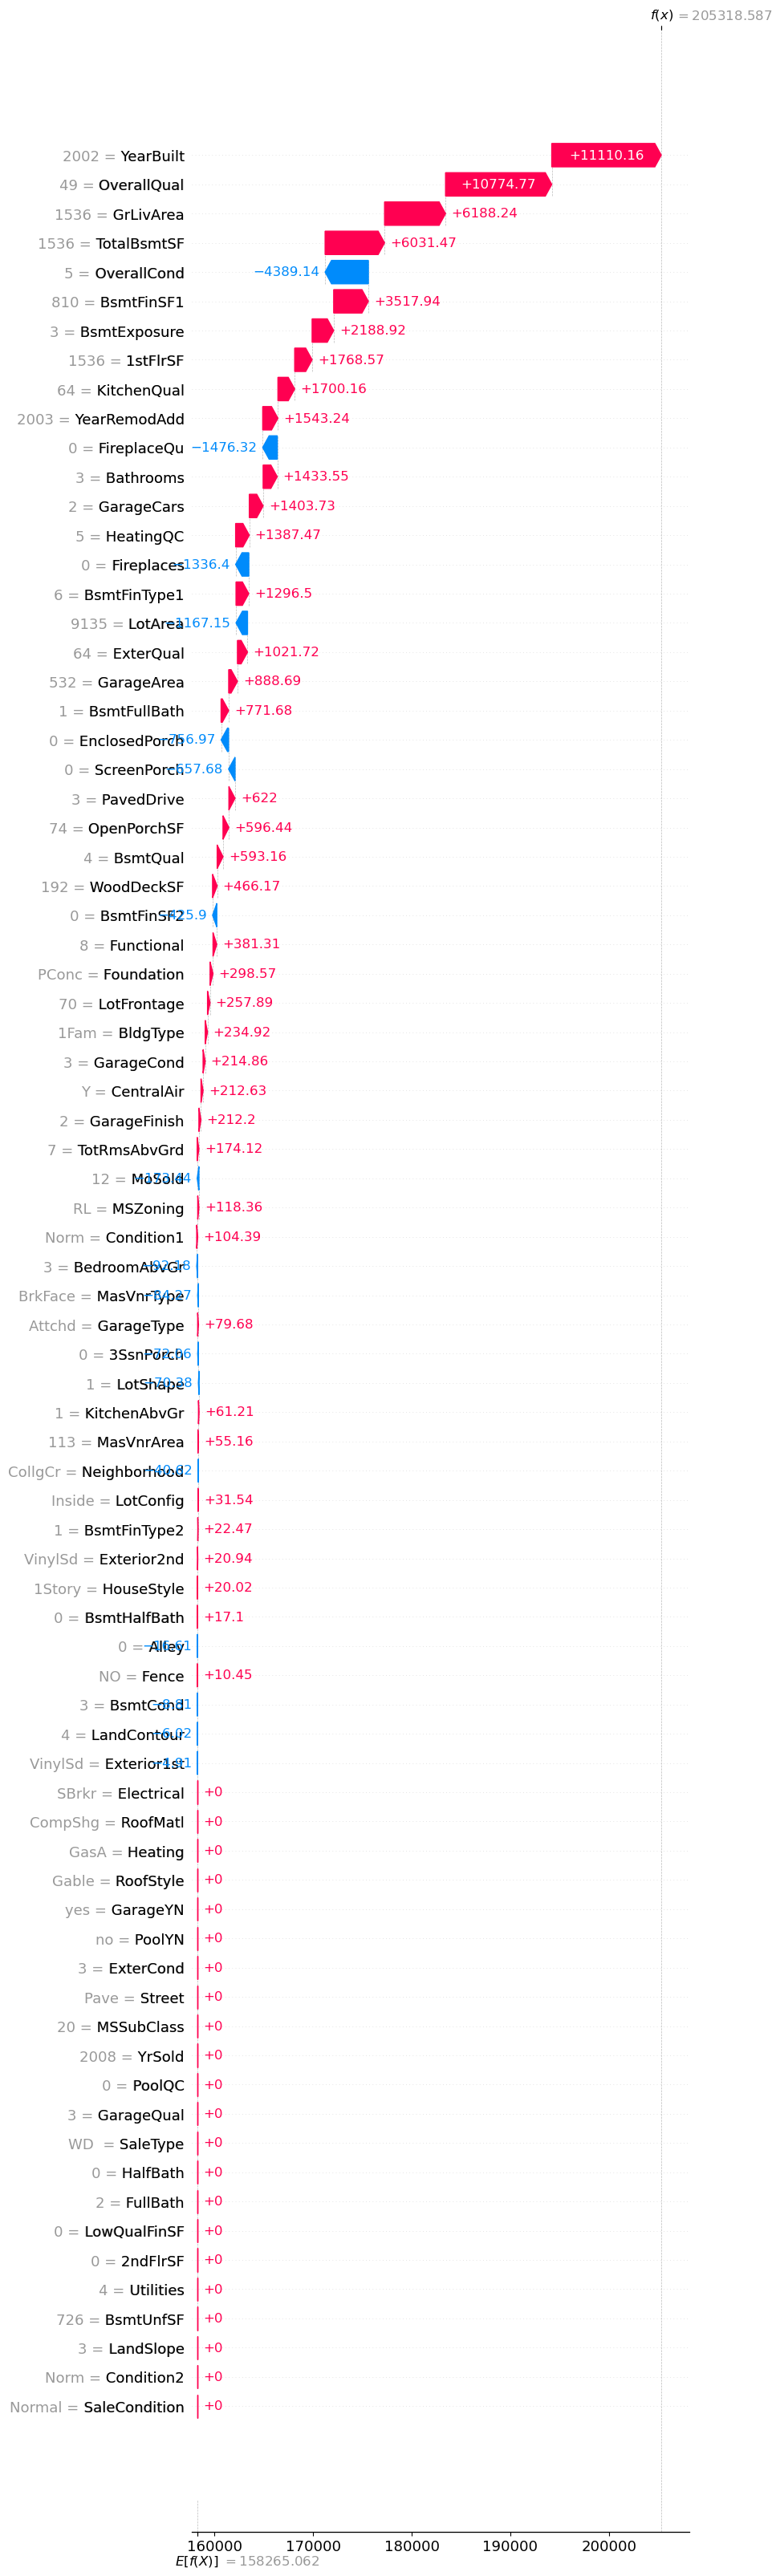

In [337]:
idx = 13
print('Actual', y[idx])
print('Prediction', predictions[idx])
shap_pred = exp.base_values[idx] + exp.values[idx].sum()
print('Difference in SHAP and Prediction = ', shap_pred - predictions[idx])
shap.waterfall_plot(exp[idx], max_display= 2254)

In [141]:
predictions[0]

125415.72820465676

In [146]:
exp_quality = shap.Explanation(dollar_shap_values.loc[:, numerical_columns_selector(X)].groupby('OverallQual').mean().values, 
                        np.exp(shap_values.base_values),
                        X.loc[:, numerical_columns_selector(X)].groupby('OverallQual').mean())


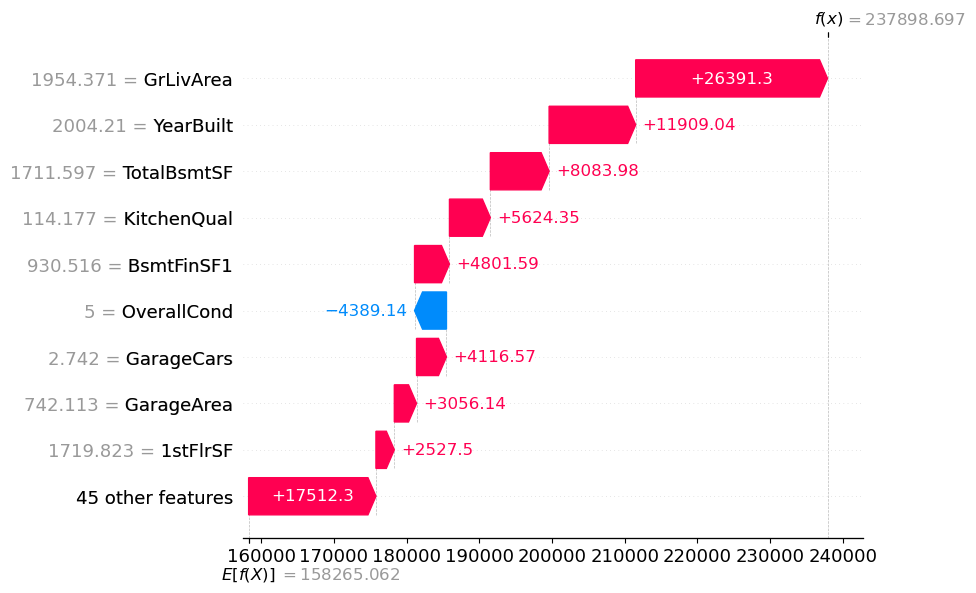

In [179]:
shap.waterfall_plot(exp_quality[8])

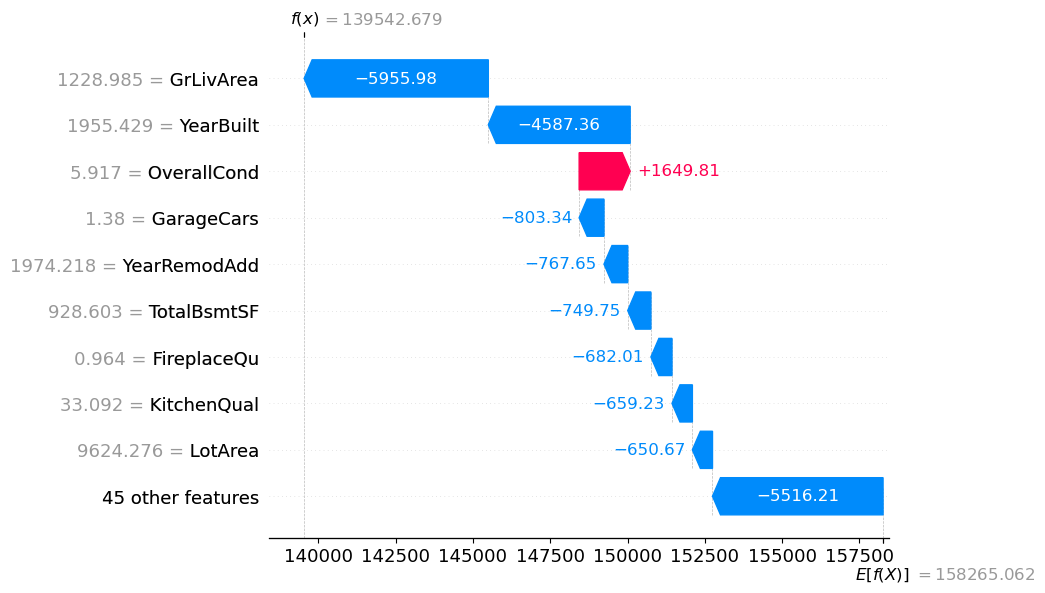

In [175]:
shap.waterfall_plot(exp_quality[4])

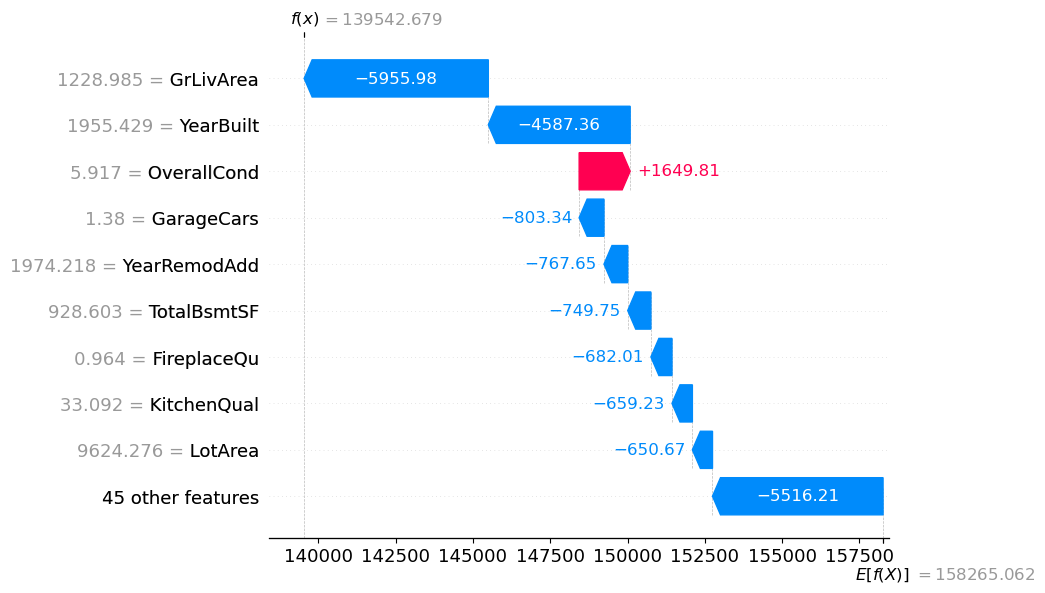

In [187]:
shap.waterfall_plot(exp_quality[4])

In [196]:
X.loc[X.GrLivArea < 1000].loc[X.OverallCond < 5].OverallQual

6       16
15       9
48      16
164      4
388      4
627     16
660      9
721      4
731      1
745     25
865     16
899     36
1026     1
1153    36
1275    25
1329     9
1339    16
1393     9
1403    16
1433    16
1499    16
1533    16
1606    16
1613    16
1751     9
1752    16
2035     4
2084     4
2236     9
2241     9
2254    16
Name: OverallQual, dtype: int64

In [193]:
X.loc[X.GrLivArea < 1000].loc[X.OverallCond < 5]

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolYN,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms
6,936,20,RM,60.000000,6000,Pave,2.0,1,3,4,...,0,0,no,0.0,NO,2,2009,WD,Normal,1.0
15,864,30,RL,45.000000,8248,Pave,1.0,1,4,4,...,0,0,no,0.0,NO,9,2008,WD,Normal,2.0
48,672,30,RM,61.000000,8534,Pave,0.0,1,1,4,...,0,0,no,0.0,GdWo,6,2006,WD,Normal,1.0
164,660,20,RL,71.261892,9000,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,6,2009,WD,Normal,1.0
388,612,30,RM,50.000000,5925,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,10,2009,WD,Normal,1.0
627,630,180,RM,21.000000,1477,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,4,2009,WD,Normal,2.0
660,894,30,C (all),120.000000,18000,Grvl,0.0,1,1,4,...,0,0,no,0.0,NO,8,2008,ConLD,Normal,1.0
721,845,50,RM,64.000000,11067,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,3,2007,WD,Normal,1.0
731,334,20,RL,50.000000,5000,Pave,0.0,1,1,4,...,0,0,no,0.0,NO,1,2007,WD,Normal,1.0
745,988,20,RL,70.000000,9100,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,7,2006,WD,Normal,2.0


In [173]:
X.LotArea - X.GrLivArea

0        7034
1        3186
2        5059
3        7107
4        6735
        ...  
2328     7902
2329    11947
2330     4268
2331     6984
2332     7643
Length: 2333, dtype: int64

In [171]:
X.LotArea

0        7890
1        4235
2        6060
3        8146
4        8400
        ...  
2328     8854
2329    13680
2330     6270
2331     8826
2332     9554
Name: LotArea, Length: 2333, dtype: int64

# Ridge

In [126]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)


ridge_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Ridge(alpha = 22.384020959927625),
                                                                func =np.log, inverse_func=np.exp))])


kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

print('score', scores.mean())

ridge_pipe.fit(X,y)

ridge_predictions = ridge_pipe.predict(X)
print('predicted prices', ridge_predictions)
mae = mean_absolute_error(y, ridge_predictions)
print('Mean Absolute Error:', mae)
mpv = ridge_predictions.mean()
print ('Mean Predicted Home Value', mpv)
mhv = y.mean()
print ('Mean  Home Value', mhv)

score 0.9508125912427354
predicted prices [124825.96716992 130562.56264385 120344.35339857 ... 149066.30368663
 224351.9667266  224004.03812094]
Mean Absolute Error: 10149.870812872321
Mean Predicted Home Value 172891.44281843473
Mean  Home Value 173427.01285897984


In [214]:
ridge_pipe.fit(X_train, y_train)
print('train', ridge_pipe.score(X_train,y_train))
print('test', ridge_pipe.score(X_test,y_test))

train 0.955884251164616
test 0.9579975589919999


In [129]:
# Create a SHAP explainer for the Lasso model
explainer = shap.Explainer(ridge_pipe.named_steps['Regressor'].regressor_,
                          masker = ridge_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values = explainer(ridge_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = ridge_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names)

# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df[prefix] = shap_values_df[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
bv = shap_values.base_values[0]
dollar_shap_values = np.exp(bv + shap_values_df) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

# Create a shap.Explanation with scaled shap values and correct feature names 
exp = shap.Explanation(dollar_shap_values.values, 
                       np.exp(shap_values.base_values),
                       X_new_order)

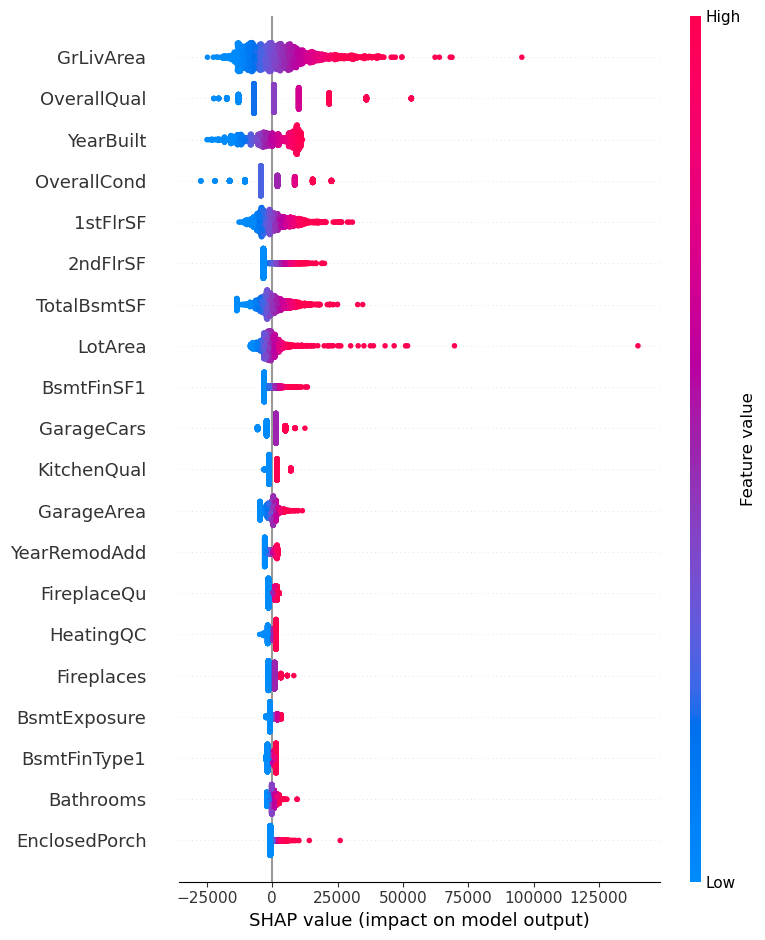

In [130]:
shap.summary_plot(exp)

Actual 114500
Prediction 121419.212852241
Difference in SHAP and Prediction =  -4090.6996437771304


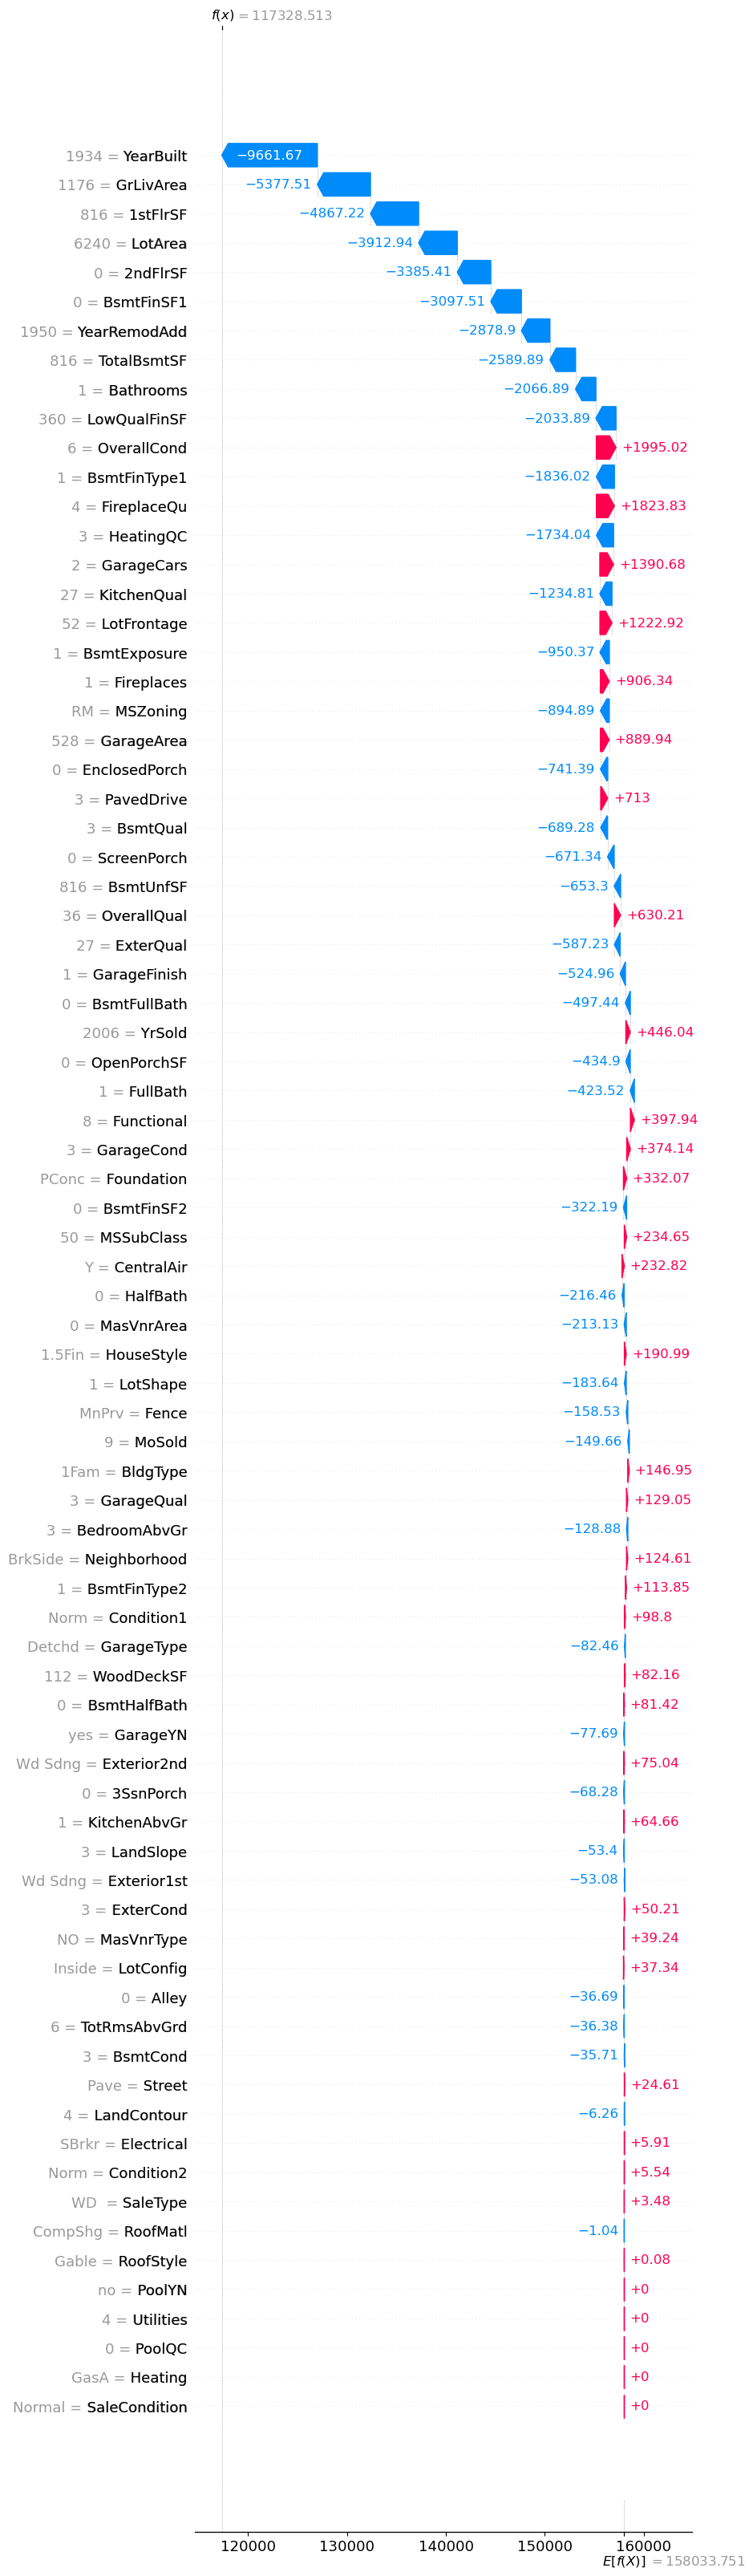

In [132]:
idx = 2250
print('Actual', y[idx])
print('Prediction', predictions[idx])
shap_pred = exp.base_values[idx] + exp.values[idx].sum()
print('Difference in SHAP and Prediction = ', shap_pred - predictions[idx])
shap.waterfall_plot(exp[idx], max_display= 90)

# XGB